### Ex 3.19: Pyramids. 
Construct an image pyramid. The inputs should be a grayscale or color image, a separable filter kernel, and the number of desired levels. Implement at least the following kernels:
- 2 × 2 block filtering;
- Burt and Adelson’s binomial kernel 1/16(1, 4, 6, 4, 1) (Burt and Adelson 1983a);
- a high-quality seven- or nine-tap filter.<br>

Compare the visual quality of the various decimation filters. Also, shift your input image by 1 to 4 pixels and compare the resulting decimated (quarter size) image sequence.


In [1]:
# import 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
# draw:
def plt_show(title,img,cmap = None):
    fig = plt.figure()
    plt.title(title)
    plt.imshow(img,cmap=cmap)
    plt.show()

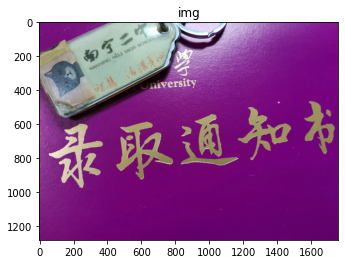

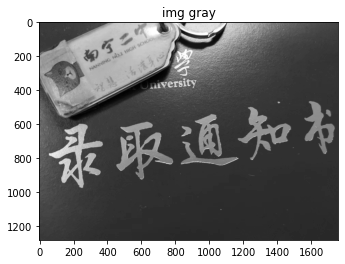

In [3]:
# load img:
img = cv2.imread('home.jpg') # (1280, 1760)

# show:
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img_color = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt_show("img",img_color)
plt_show("img gray",img_gray,cmap="gray")

#### Filters Definition:
- 2*2 block filtering:<br>
`1/4*[[1,1],[1,1]]` <br>
or `1/2*[[1],[1]]*1/2*[1,1]`<br>
And I wanna to figure out the differences between them.
- binomial kernel:<br> 
definition: 
http://www.fmwconcepts.com/imagemagick/binomial/index.php#:~:text=Similarly%2C%20b%20is%20the%20binomial%20kernel%2C%20formed%20from,do%20one%20convolution%20using%20the%20convolution%20kernel%2C%20f.<br>
The
kernel weights are based upon the binomial coefficients.(Pascal's triangle)<br>
5-tap: `1/16(1,4,6,4,1)`
7-tap: `1/64(1,6,15, 20, 15, 6, 1)`
9-tap: `1/256(1,8,28,56,70,56,28,8,1)`
- 


In [4]:
# filter define:
block_filter_1 = np.array(([1/2],[1/2]))
block_filter_2 = np.array(([1/4,1/4],[1/4,1/4]))
binomial_kernel = np.array([1/16,1/4,6/16,1/4,1/16])

In [5]:
def int2uint(number):
    if len(number.shape)>1:
        # number[number<0] = 0
        number[number>255] = 255
    else:
        if number<0:
            number =  0
        if number>255:
            number = 255
    return number.astype('uint8')

In [6]:
# conv with 1D kernel:
def conv(img,kernel,axis,fill=False):
    img_copy = copy.deepcopy(img)
    img_copy = np.array(img_copy,dtype='int')
    # need to be filled:
    if fill:
        padding = len(kernel)//2
        if axis ==0:
            img_copy = np.pad(img_copy,((padding,padding),(0,0)),'constant',constant_values = ((0,0),(0,0)))
        else:
            img_copy = np.pad(img_copy,((0,0),(padding,padding)),'constant',constant_values = ((0,0),(0,0)))
    # conv size:
    conv_length = img_copy.shape[axis]-len(kernel)+1
    conv_res = 0
    if axis==0:
        conv_res = np.zeros((conv_length,img_copy.shape[1]),dtype='uint8')
        for j in range(img_copy.shape[1]):
            for i in range(conv_length):
                temp = np.dot(img_copy[i:i+len(kernel),j],kernel).sum()
                if temp>255:
                    temp = 255
                conv_res[i][j] = temp
    else:
        conv_res = np.zeros((img_copy.shape[0],conv_length),dtype='uint8')
        for i in range(img_copy.shape[0]):
            for j in range(conv_length):
                temp = np.dot(img_copy[i,j:j+len(kernel)],kernel).sum()
                if temp>255:
                    temp = 255
                conv_res[i][j] = temp

    return conv_res 

In [7]:
# conv with 2D kernel
def conv_v2(img,kernel,fill = False):
    img_copy = copy.deepcopy(img)
    img_copy = np.array(img_copy,dtype='int')
    # padding:
    if fill:
        w_padding = kernel.shape[0]//2
        l_padding = kernel.shape[1]//2
        img_copy = np.pad(img_copy,((w_padding,w_padding),(l_padding,l_padding)),'constant',constant_values = ((0,0),(0,0)))
    # conv:
    conv_width = img_copy.shape[0]-kernel.shape[0]+1
    conv_length = img_copy.shape[1]-kernel.shape[1]+1
    conv_res  =  np.zeros((conv_width,conv_length),dtype='uint8')
    for i in range(conv_width):
        for j in range(conv_length):
            temp = np.multiply(img_copy[i:i+kernel.shape[0],j:j+kernel.shape[1]],kernel).sum()
            if temp>255:
                temp = 255
            conv_res[i][j] = temp
    return conv_res

In [8]:
# 下采样操作：
def downsample(img_conv,width,length,axis):
    img_down = np.zeros((width,length),dtype='uint8')
    index = 0
    for i in range(0,img_conv.shape[axis],2):
        if axis==0:
            if index>=width:
                break
            img_down[index,:] = img_conv[i,:]
        else:
            if index>=length:
                break
            img_down[:,index] = img_conv[:,i]
        index+=1
        
    return img_down

In [9]:
# 上采样操作：
def oversample(img_down,axis):
    if axis==0:
        img_up = np.zeros((img_down.shape[0]*2,img_down.shape[1]),dtype='uint8')
        for i in range(0,img_down.shape[0]):
            img_up[i*2,:] = img_down[i,:]
            img_up[i*2+1,:] = 0
    else:
        img_up = np.zeros((img_down.shape[0],img_down.shape[1]*2),dtype='uint8')
        for i in range(0,img_down.shape[1]):
            img_up[:,i*2] = img_down[:,i]
            img_up[:,i*2+1] = 0
    return img_up

In [10]:
# 高斯金字塔和拉普拉斯金字塔同时构建：
def pyramid(img,kernel,level):
    img_global = copy.deepcopy(img)
    plt_show("I0",img,cmap="gray")
    img_laplacian = []
    for i in range(level):
        img_level = []
        # 1D kernel:
        img_conv = 0
        if len(kernel.shape)==1:
            # H(w)&downsample:
            # row:
            img_conv = conv(img_global,kernel,0)
            img_down = downsample(img_conv,img_conv.shape[0]//2,img_conv.shape[1],0)
            # column:
            img_conv = conv(img_down,kernel,1)
            img_down = downsample(img_conv,img_conv.shape[0],img_conv.shape[1]//2,1)
            plt_show("I"+str(i+1),img_down,cmap="gray")
            img_level.append(img_down)
            

            # oversample&G(w):
            # column:
            img_up = oversample(img_down,1)
            img_conv = conv(img_up,kernel,1)
            img_conv*=2 # G(w) = H(w)*2
            # row:
            img_up = oversample(img_conv,0)
            img_conv = conv(img_up,kernel,0)
            img_conv*=2
        elif len(kernel.shape)==2:
            # H(w)&downsample:
            img_conv = conv_v2(img_global,kernel)
            # downsample:
            img_down = downsample(img_conv,img_conv.shape[0]//2,img_conv.shape[1],0)
            img_down = downsample(img_down,img_down.shape[0],img_down.shape[1]//2,1)
            plt_show("I"+str(i+1),img_down,cmap="gray")
            img_level.append(img_down)

            # oversample&G(w):
            img_up = oversample(img_down,1)
            img_up = oversample(img_up,0)
            img_conv = conv_v2(img_up,kernel)
            img_conv*=2 # G(w) = H(w)*2

        # b:
        height = min(img_global.shape[0],img_conv.shape[0])
        length = min(img_global.shape[1],img_conv.shape[1])
        img_coff = np.array(img_global[:height,:length],dtype='int')-np.array(img_conv[:height,:length],dtype='int')
        # img_coff = img_global-img_conv[0:img_global.shape[0],0:img_global.shape[1]]
        # img_coff = int2uint(img_coff)a
        plt_show("b"+str(i),img_coff,cmap="gray")
        img_level.append(img_coff)
        img_laplacian.append(img_level)

        # recursive:
        img_global = img_down
    return img_laplacian
    

In [11]:
def pyramid_v2(img,kernel,level):
    img_global = copy.deepcopy(img)
    plt_show("I0",img,cmap="gray")
    img_laplacian = []
    for i in range(level): 
        img_level = []
        # H(w)&downsample:
        img_conv = conv_v2(img_global,kernel)
        # downsample:
        img_down = downsample(img_conv,img_conv.shape[0]//2,img_conv.shape[1],0)
        img_down = downsample(img_down,img_down.shape[0],img_down.shape[1]//2,1)
        plt_show("I"+str(i+1),img_down,cmap="gray")
        img_level.append(img_down)

        # oversample&G(w):
        img_up = oversample(img_down,1)
        img_up = oversample(img_up,0)
        img_conv = conv_v2(img_up,kernel)
        img_conv*=2 # G(w) = H(w)*2

        # b:
        img_coff = img_global-img_conv[0:img_global.shape[0],0:img_global.shape[1]]
        img_coff = int2uint(img_coff)
        plt_show("b"+str(i),img_coff,cmap="gray")
        img_level.append(img_coff)
        img_laplacian.append(img_level)

        # recursive:
        img_global = img_down
    return img_laplacian

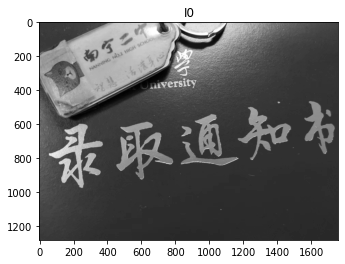

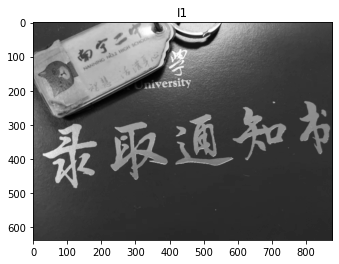

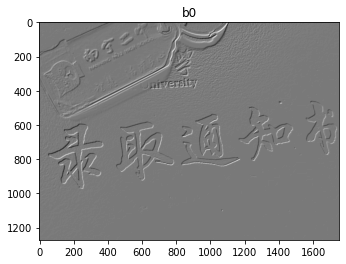

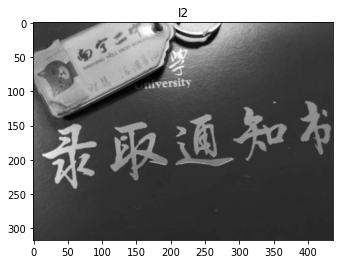

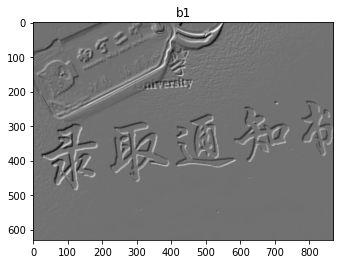

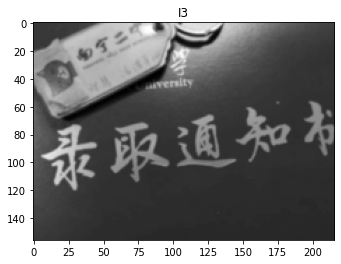

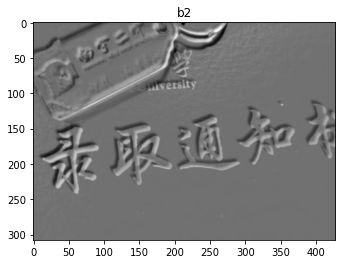

In [12]:
# img gray with Binomial Kernel:
img_laplacian = pyramid(img_gray,binomial_kernel,3)

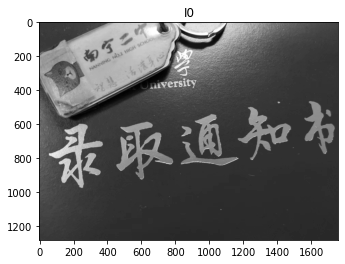

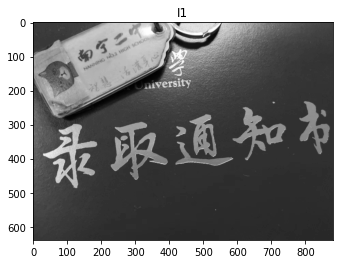

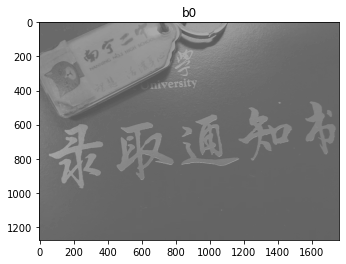

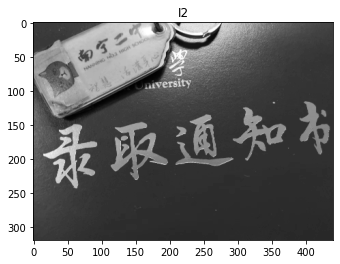

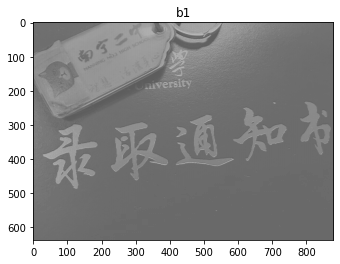

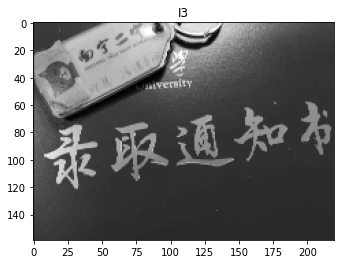

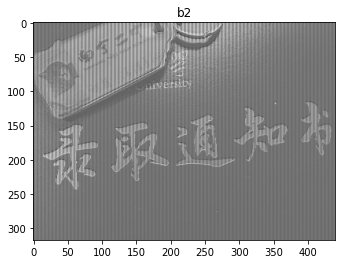

In [13]:
# img gray with block_filter_1: 分离的
img_laplacian_bf1 = pyramid(img_gray,block_filter_1,3)

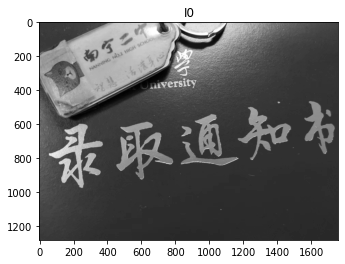

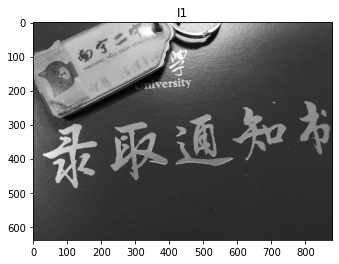

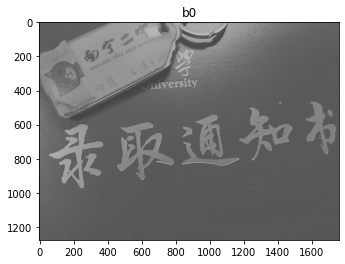

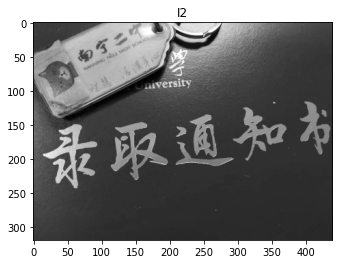

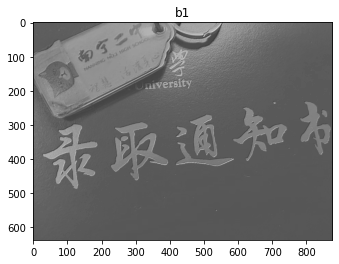

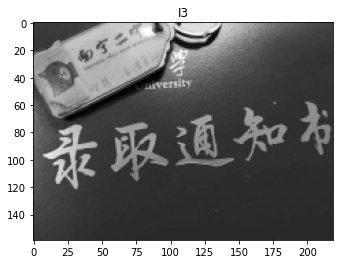

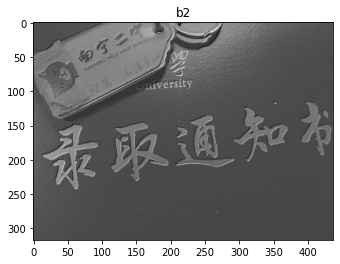

In [14]:
# img gray with 2D filter: 不分离的
img_laplacian_bf2 = pyramid(img_gray,block_filter_2,3)

In [15]:
# color img pyramids:
def color_pyramids(img,kernel,level):
    # seperate three channels and pyramids respectively.
    img_b,img_g,img_r = cv2.split(img)
    r_laplacian = pyramid(img_r,kernel,level)
    g_laplacian = pyramid(img_g,kernel,level)
    b_laplacian = pyramid(img_b,kernel,level)
    # color img merge:
    img_color_laplacian = []
    for i in range(level):
        data1 = cv2.merge([r_laplacian[i][0],g_laplacian[i][0],b_laplacian[i][0]])
        data2 = cv2.merge([r_laplacian[i][1],g_laplacian[i][1],b_laplacian[i][1]])
        single = []
        single.append(data1)
        single.append(data2)
        img_color_laplacian.append(single)    
    return img_color_laplacian

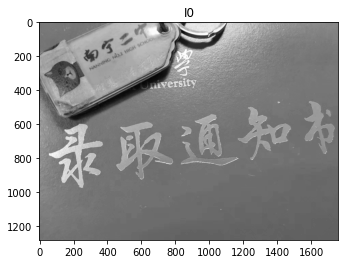

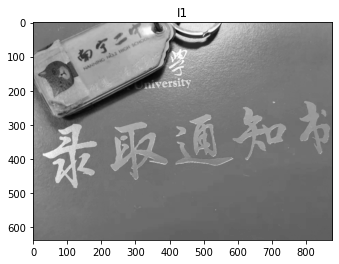

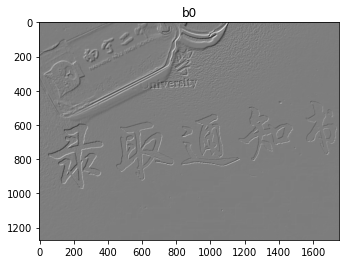

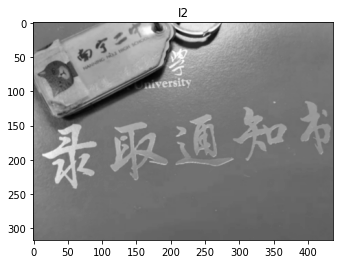

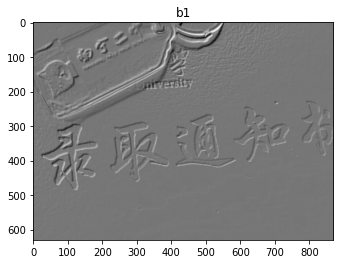

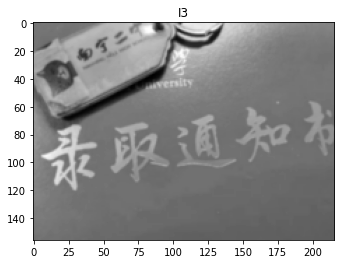

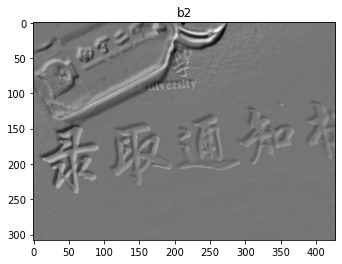

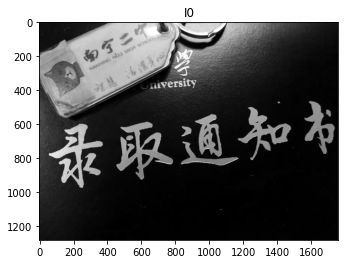

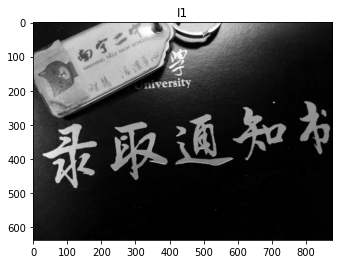

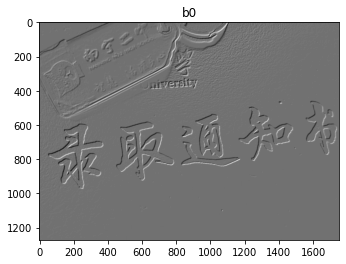

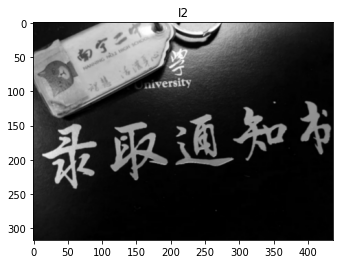

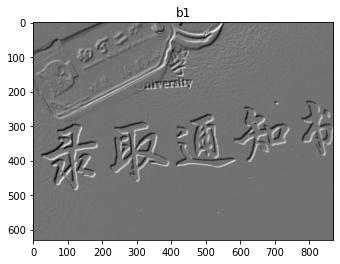

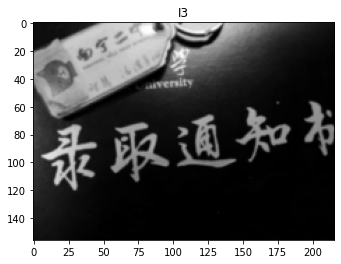

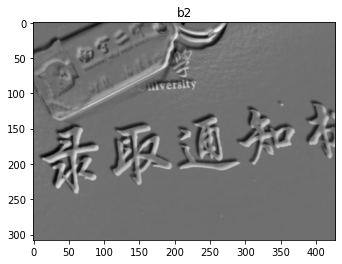

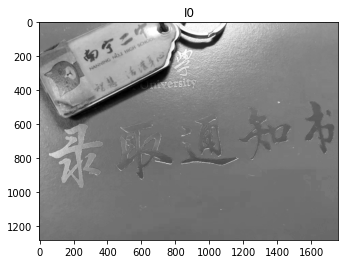

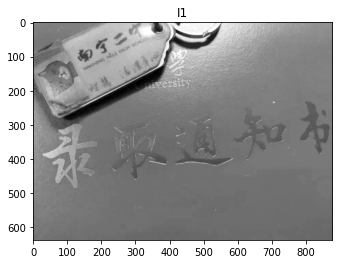

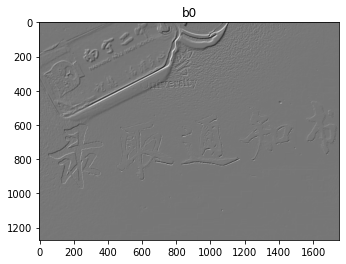

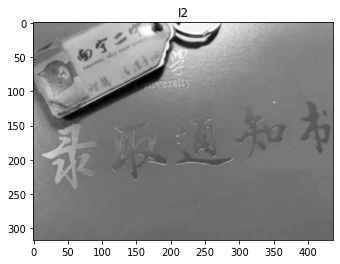

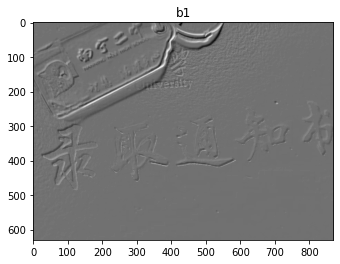

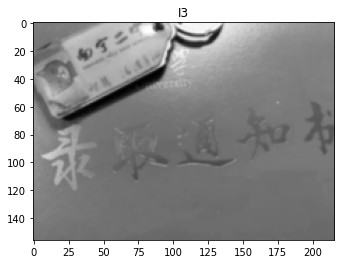

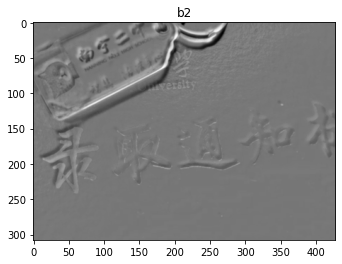

In [16]:
# color img:
img_color_laplacian = color_pyramids(img,binomial_kernel,3)

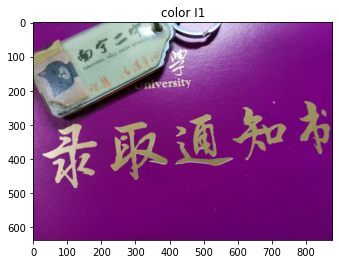

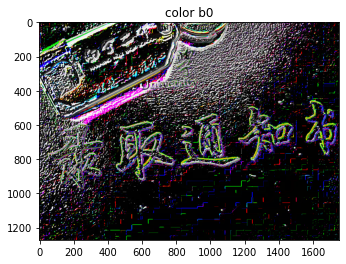

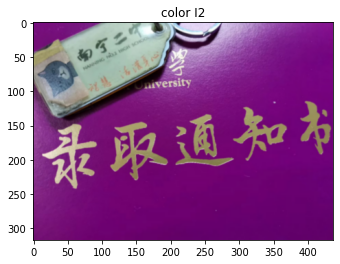

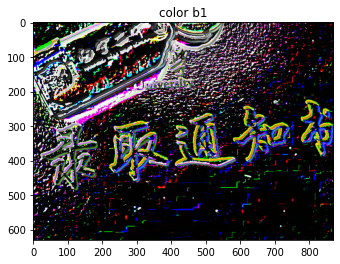

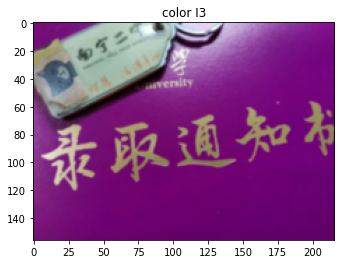

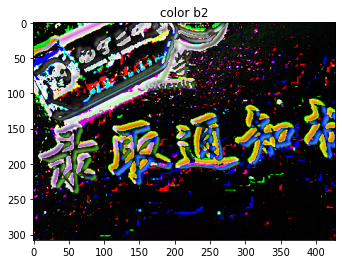

In [17]:
for i in range(0,3):
    plt_show("color I"+str(i+1),img_color_laplacian[i][0])
    plt_show("color b"+str(i),int2uint(img_color_laplacian[i][1]))

In [18]:
# 探究平移效果：
# shift 1-4 pixels and compare 1/4 downsampling results.
def img_shift(img,pixel,direction):
    img_shif = np.zeros((img.shape))
    # left:
    if direction==-1:
        img_shif[:,:-1*pixel] = img[:,pixel:]
    # right:
    if direction==1:
        img_shif[:,pixel:] = img[:,:-1*pixel] 
    return img_shif

In [22]:
# 对图像构建高斯金字塔：使用cv2.pyrDown()
def gauss_pyramid(img,level):
    gauss_pyr = []
    img_c = copy.deepcopy(img)
    # 放原图作为第零层：
    gauss_pyr.append(img_c)
    for i in range(level):
        img_c = cv2.pyrDown(img_c)
        plt_show("gauss pyr layer = {}".format(i+1),img_c,cmap="gray")
        gauss_pyr.append(img_c)
    return gauss_pyr

In [23]:
# 拉普拉斯金字塔：使用cv2.pyrUp()构建：
def lap_pyramid(gauss_pyr,level):
    lap_pyr = []
    for i in range(1,level+1):
        # expand:
        temp = cv2.pyrUp(gauss_pyr[i]) 
        # substract:
        width = min(gauss_pyr[i-1].shape[0],temp.shape[0])
        length = min(gauss_pyr[i-1].shape[1],temp.shape[1])
        a = np.array(gauss_pyr[i-1][:width,:length],dtype='int')
        b = np.array(temp[:width,:length],dtype='int')
        sub = a-b
        plt_show("lap lay={}".format(i-1),sub,cmap="gray")
        lap_pyr.append(sub)
    lap_pyr.append(gauss_pyr[level])
    return lap_pyr

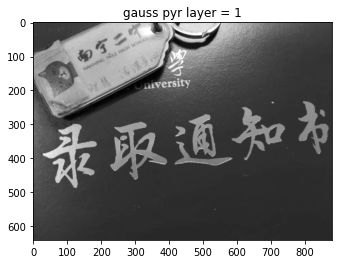

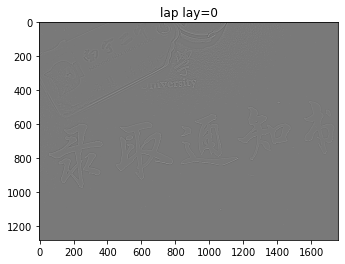

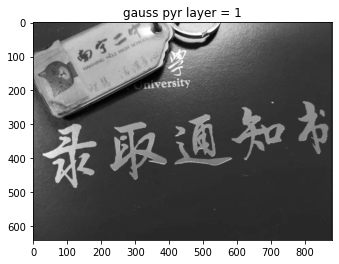

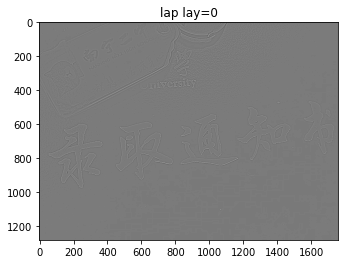

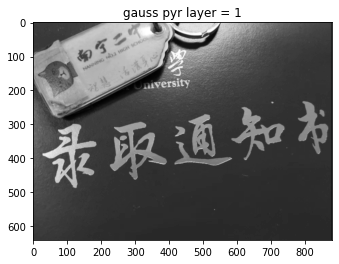

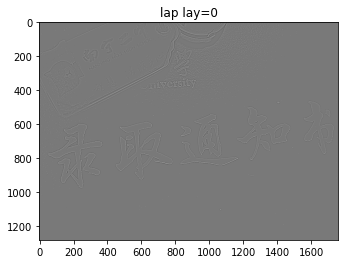

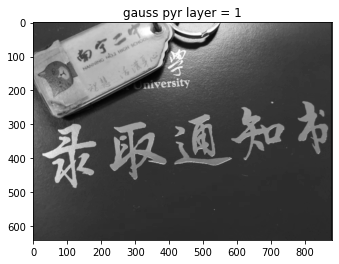

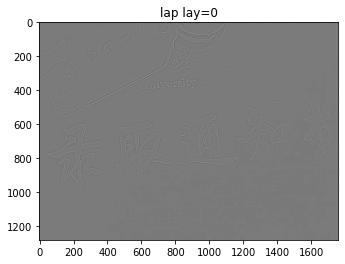

In [34]:
shift_res = []
shift_gauss = []
shift_lap = []
for i in range(1,5):
    # left shift
    img_shif_l = img_shift(img_gray,i,-1)
    shift_res.append(img_shif_l)
    # gauss:
    t = gauss_pyramid(img_shif_l,1)
    shift_gauss.append(t)
    # lap:
    shift_lap.append(lap_pyramid(t,1))

In [39]:
# 写入文件中查看：
for i in range(0,4):
    t =  np.array(shift_gauss[i][1],dtype='int')
    tt = np.array(shift_lap[i][1],dtype='int')
    np.savetxt("gauss shift = {}.txt".format(i), t,fmt="%d")
    np.savetxt("lap shift = {}.txt".format(i), tt,fmt="%d")

In [42]:
# 打印查看：
for i in range(0,4):
    t =  np.array(shift_gauss[i][1],dtype='int')
    print(t)

[[67 66 64 ... 68 69 52]
 [66 66 64 ... 68 68 51]
 [65 65 65 ... 68 68 51]
 ...
 [58 58 58 ... 42 41 31]
 [58 58 58 ... 42 41 31]
 [59 59 58 ... 42 41 30]]
[[66 64 64 ... 69 65 21]
 [66 65 64 ... 68 64 21]
 [65 65 65 ... 68 63 21]
 ...
 [58 58 57 ... 42 39 13]
 [58 58 58 ... 41 39 12]
 [59 59 58 ... 41 38 12]]
[[65 64 65 ... 69 48  4]
 [65 64 65 ... 68 47  4]
 [65 65 64 ... 68 46  4]
 ...
 [58 58 57 ... 41 28  2]
 [58 58 58 ... 41 28  2]
 [59 58 58 ... 41 28  2]]
[[64 64 65 ... 65 21  0]
 [64 64 65 ... 64 21  0]
 [66 65 64 ... 63 21  0]
 ...
 [58 57 57 ... 39 13  0]
 [58 58 58 ... 39 12  0]
 [59 58 58 ... 38 12  0]]


In [41]:
# 打印查看：
for i in range(0,4):
    t =  np.array(shift_lap[i][1],dtype='int')
    print(t)

[[67 66 64 ... 68 69 52]
 [66 66 64 ... 68 68 51]
 [65 65 65 ... 68 68 51]
 ...
 [58 58 58 ... 42 41 31]
 [58 58 58 ... 42 41 31]
 [59 59 58 ... 42 41 30]]
[[66 64 64 ... 69 65 21]
 [66 65 64 ... 68 64 21]
 [65 65 65 ... 68 63 21]
 ...
 [58 58 57 ... 42 39 13]
 [58 58 58 ... 41 39 12]
 [59 59 58 ... 41 38 12]]
[[65 64 65 ... 69 48  4]
 [65 64 65 ... 68 47  4]
 [65 65 64 ... 68 46  4]
 ...
 [58 58 57 ... 41 28  2]
 [58 58 58 ... 41 28  2]
 [59 58 58 ... 41 28  2]]
[[64 64 65 ... 65 21  0]
 [64 64 65 ... 64 21  0]
 [66 65 64 ... 63 21  0]
 ...
 [58 57 57 ... 39 13  0]
 [58 58 58 ... 39 12  0]
 [59 58 58 ... 38 12  0]]


发现有部分图像存在平移的对应，但并不是十分对齐；由于是执行左移，因此在右边填0，而填0后由于重新卷积，因此右边图像边界部分并没有和平移相对应。按照卷积的平移不变性，在经过高斯核卷积处理时应不会改变图像结构，而且下采样以及上采样操作隔行隔列添0或删减，亦不会改变图像的结构。因此高斯金字塔和拉普拉斯金字塔应该具有平移相对应的属性。